# 1. Import bibliothèques et chemins données

In [ ]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from tqdm import tqdm
import librosa

from transformers import BertTokenizer, BertModel
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
from scipy.stats import pearsonr
from torch.utils.data import Dataset, DataLoader

#régler compatibilités numpy
np.set_printoptions(legacy='1.21')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#chemins données : à modifier selon configuration
DATA_PATH = Path(r"C:\Users\tmath\.cache\kagglehub\datasets\argish\meld-preprocessed\versions\1\preprocessed_data")
TRAIN_PATH = DATA_PATH / "train"
DEV_PATH = DATA_PATH / "dev"
TEST_PATH = DATA_PATH / "test"

print(f"\nData paths:")
print(f"Data: {DATA_PATH}")
print(f"Train: {TRAIN_PATH}")
print(f"Dev: {DEV_PATH}")
print(f"Test: {TEST_PATH}")

# Vérifier que les chemins existent
for path_name, path in [("Train", TRAIN_PATH), ("Dev", DEV_PATH), ("Test", TEST_PATH)]:
    if path.exists():
        print(f"{path_name} folder found: {len(list(path.glob('*.pt')))} .pt files")
    else:
        print(f"{path_name} folder NOT found: {path}")

Using device: cpu

Data paths:
Data: C:\Users\tmath\.cache\kagglehub\datasets\argish\meld-preprocessed\versions\1\preprocessed_data
Train: C:\Users\tmath\.cache\kagglehub\datasets\argish\meld-preprocessed\versions\1\preprocessed_data\train
Dev: C:\Users\tmath\.cache\kagglehub\datasets\argish\meld-preprocessed\versions\1\preprocessed_data\dev
Test: C:\Users\tmath\.cache\kagglehub\datasets\argish\meld-preprocessed\versions\1\preprocessed_data\test
Train folder found: 9988 .pt files
Dev folder found: 1108 .pt files
Test folder found: 2610 .pt files
Train folder found: 9988 .pt files
Dev folder found: 1108 .pt files
Test folder found: 2610 .pt files


# 2. Chargement des Données MELD

Les données MELD contiennent:
- **data_sentiment.p**: Liste de dictionnaires avec texte, label, dialogue_id, etc.
- **audio_sentiment.pkl**: Features audio pré-extraites
- **CSV files**: Métadonnées (Sr No, Utterance, Speaker, Emotion, Sentiment...)

In [3]:
def load_meld_data():
    #chargement données
    print("Charger données MELD preprocessed avec fichiers .pt...")
    
    data = {}
    
    for split_name, split_path in [('train', TRAIN_PATH), ('dev', DEV_PATH), ('test', TEST_PATH)]:
        split_data = []
        pt_files = sorted(split_path.glob('*.pt'))
        
        print(f"\n{split_name.upper()}: Loading {len(pt_files)} files...")
        
        for pt_file in tqdm(pt_files, desc=f"Loading {split_name}"):
            try:
                #charger le fichier .pt
                sample = torch.load(pt_file, weights_only=False)
                
                #extractions
                data_item = {
                    'text': sample.get('utterance', sample.get('text', '')),
                    'y': sample.get('label', sample.get('sentiment', 'neutral')).lower(),
                    'emotion': sample.get('emotion', 'neutral').lower(),
                    'split': split_name
                }
                
                #ajout autres infos si disponibles
                if 'dialogue_id' in sample:
                    data_item['dialogue_id'] = sample['dialogue_id']
                if 'utterance_id' in sample:
                    data_item['utterance_id'] = sample['utterance_id']
                if 'speaker' in sample:
                    data_item['speaker'] = sample['speaker']
                
                split_data.append(data_item)
            except Exception as e:
                print(f" Errorloading {pt_file.name}: {e}")
                continue
        
        data[split_name] = split_data
        print(f" Loaded {len(split_data)} samples from {split_name}")
    
    print(f"\nDataset sizes:")
    for split, items in data.items():
        print(f"  {split}: {len(items)} samples")
    
    return data


def convert_sentiment_to_score(sentiment):
    #conversion label sentiment en score numérique
    mapping = {
        'positive': 1.0,
        'negative': -1.0,
        'neutral': 0.0
    }
    return mapping.get(sentiment, 0.0)


#chargement données
meld_data = load_meld_data()

Charger données MELD preprocessed avec fichiers .pt...

TRAIN: Loading 9988 files...


Loading train: 100%|██████████| 9988/9988 [02:40<00:00, 62.31it/s]



 Loaded 9988 samples from train

DEV: Loading 1108 files...


Loading dev: 100%|██████████| 1108/1108 [00:18<00:00, 58.46it/s]



 Loaded 1108 samples from dev

TEST: Loading 2610 files...


Loading test: 100%|██████████| 2610/2610 [00:43<00:00, 60.32it/s]

 Loaded 2610 samples from test

Dataset sizes:
  train: 9988 samples
  dev: 1108 samples
  test: 2610 samples


# 3. Analyse de la distribution et sampling

Les données prétraités MELD sont beaucoup plus volumineuses. On va analyser la distribution et faire un sampling stratifié pour les rendre traitables.

In [4]:
import random

print("ANALYSE DE LA DISTRIBUTION DES DONNÉES")

#analyse distribution sentiments et émotions
for split_name in ['train', 'dev', 'test']:
    print(f"\n{split_name.upper()}:")
    data = meld_data[split_name]
    
    #distribution sentiments
    sentiment_counts = {}
    emotion_counts = {}
    for sample in data:
        s = sample['y']
        e = sample['emotion']
        sentiment_counts[s] = sentiment_counts.get(s, 0) + 1
        emotion_counts[e] = emotion_counts.get(e, 0) + 1
    
    print(f"  Sentiments: {sentiment_counts}")
    print(f"  Emotions: {emotion_counts}")

#sampling
print("SAMPLING (pour rendre les données traitables)")

def stratified_sample(data, target_size=1000, random_seed=42):
    #sampling simple
    random.seed(random_seed)
    
    #grouper par sentiments
    by_sentiment = {}
    for sample in data:
        s = sample['y']
        if s not in by_sentiment:
            by_sentiment[s] = []
        by_sentiment[s].append(sample)
    
    #samples par sentiment
    samples_per_sentiment = target_size // len(by_sentiment)
    
    result = []
    for sentiment, items in by_sentiment.items():
        sampled = random.sample(items, min(samples_per_sentiment, len(items)))
        result.extend(sampled)
    
    random.shuffle(result)
    return result[:target_size]

#aplliquer sampling
print("\n500 samples par split...")
meld_data_sampled = {
    'train': stratified_sample(meld_data['train'], target_size=500),
    'dev': stratified_sample(meld_data['dev'], target_size=200),
    'test': stratified_sample(meld_data['test'], target_size=300)
}

#vérification la distribution
for split_name in ['train', 'dev', 'test']:
    print(f"\n{split_name.upper()} (sampled):")
    data = meld_data_sampled[split_name]
    
    sentiment_counts = {}
    for sample in data:
        s = sample['y']
        sentiment_counts[s] = sentiment_counts.get(s, 0) + 1
    
    print(f"  Taille : {len(data)}")
    print(f"  Sentiments: {sentiment_counts}")

print("\nData sampling ok")


ANALYSE DE LA DISTRIBUTION DES DONNÉES

TRAIN:
  Sentiments: {'neutral': 9988}
  Emotions: {'neutral': 4709, 'fear': 268, 'surprise': 1205, 'disgust': 271, 'anger': 1109, 'joy': 1743, 'sadness': 683}

DEV:
  Sentiments: {'neutral': 1108}
  Emotions: {'sadness': 111, 'surprise': 150, 'neutral': 469, 'joy': 163, 'fear': 40, 'anger': 153, 'disgust': 22}

TEST:
  Sentiments: {'neutral': 2610}
  Emotions: {'surprise': 281, 'anger': 345, 'neutral': 1256, 'sadness': 208, 'fear': 50, 'joy': 402, 'disgust': 68}
SAMPLING (pour rendre les données traitables)

500 samples par split...

TRAIN (sampled):
  Taille : 500
  Sentiments: {'neutral': 500}

DEV (sampled):
  Taille : 200
  Sentiments: {'neutral': 200}

TEST (sampled):
  Taille : 300
  Sentiments: {'neutral': 300}

Data sampling ok


# 4. Exploration structure .pt

In [5]:
print("EXPLORATION DE LA STRUCTURE D'UN FICHIER .PT")

#charger un fichier pour exploration
sample_file = list(TRAIN_PATH.glob('*.pt'))[0]
print(f"\nExamining: {sample_file.name}")

sample = torch.load(sample_file, weights_only=False)
print(f"\nType: {type(sample)}")
print(f"Keys: {sample.keys() if isinstance(sample, dict) else 'N/A'}")

print(f"\nContents:")
if isinstance(sample, dict):
    for key, value in sample.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key}: {type(value)} - shape {value.shape}, dtype {value.dtype}")
        else:
            print(f"  {key}: {type(value)} - {value}")
else:
    print(f"  {sample}")


EXPLORATION DE LA STRUCTURE D'UN FICHIER .PT

Examining: dia0_utt0.pt

Type: <class 'dict'>
Keys: dict_keys(['utterance', 'emotion', 'video_path', 'audio', 'audio_sample_rate', 'audio_mel', 'face'])

Contents:
  utterance: <class 'str'> - also I was the point person on my company’s transition from the KL-5 to GR-6 system.
  emotion: <class 'str'> - neutral
  video_path: <class 'str'> - data/MELD/train/train_splits/dia0_utt0.mp4
  audio: <class 'torch.Tensor'> - shape torch.Size([1, 90795]), dtype torch.float32
  audio_sample_rate: <class 'int'> - 16000
  audio_mel: <class 'torch.Tensor'> - shape torch.Size([1, 64, 568]), dtype torch.float32
  face: <class 'numpy.ndarray'> - [[[69 63 68]
  [69 63 68]
  [70 64 69]
  ...
  [32 21 16]
  [31 20 15]
  [31 20 15]]

 [[69 63 68]
  [69 63 68]
  [69 64 69]
  ...
  [32 21 16]
  [31 20 15]
  [31 20 15]]

 [[69 64 68]
  [69 64 68]
  [69 65 68]
  ...
  [32 21 15]
  [32 20 15]
  [32 20 15]]

 ...

 [[38 34 28]
  [38 34 28]
  [37 33 27]
  ...
  [47 35

# 5. Mapping emotion vers sentiment

In [6]:
print("CRÉATION DU MAPPING ÉMOTION -> SENTIMENT")

def emotion_to_sentiment(emotion):
    #mapping basé sur la psychologie des émotions
    emotion = emotion.lower()
    
    positive_emotions = ['joy', 'surprise']
    negative_emotions = ['sadness', 'anger', 'fear', 'disgust']
    
    if emotion in positive_emotions:
        return 'positive'
    elif emotion in negative_emotions:
        return 'negative'
    else:
        return 'neutral'

#test mapping
print("\nTesting emotion -> sentiment mapping:")
test_emotions = ['joy', 'sadness', 'anger', 'fear', 'surprise', 'disgust', 'neutral']
for e in test_emotions:
    s = emotion_to_sentiment(e)
    print(f"  {e:10s} -> {s}")

#rechager données avec sentiment dérivé
print("RECHARGEMENT DES DONNÉES AVEC SENTIMENT DÉRIVÉ")

def load_meld_data_with_sentiment():
    #charger les données MLD
    print("Chargement données depuis les .pt...")
    
    data = {}
    
    for split_name, split_path in [('train', TRAIN_PATH), ('dev', DEV_PATH), ('test', TEST_PATH)]:
        split_data = []
        pt_files = sorted(split_path.glob('*.pt'))
        
        print(f"\n{split_name.upper()}: Loading {len(pt_files)} files...")
        
        for pt_file in tqdm(pt_files, desc=f"Loading {split_name}"):
            try:
                # Charger le fichier .pt
                sample = torch.load(pt_file, weights_only=False)
                
                # Extraire les informations pertinentes
                emotion = sample.get('emotion', 'neutral').lower()
                sentiment = emotion_to_sentiment(emotion)
                
                data_item = {
                    'text': sample.get('utterance', ''),
                    'y': sentiment,  #sentiment cible
                    'emotion': emotion,
                    'split': split_name,
                    'audio': sample.get('audio'),
                    'audio_mel': sample.get('audio_mel'),
                    'face': sample.get('face'),
                }
                
                split_data.append(data_item)
            except Exception as e:
                print(f" Error de chargement {pt_file.name}: {e}")
                continue
        
        data[split_name] = split_data
        print(f"✓ Loaded {len(split_data)} samples from {split_name}")
    
    print(f"\nDataset sizes:")
    for split, items in data.items():
        print(f"  {split}: {len(items)} samples")
    
    return data

#charger avec les sentiments
meld_data = load_meld_data_with_sentiment()


CRÉATION DU MAPPING ÉMOTION -> SENTIMENT

Testing emotion -> sentiment mapping:
  joy        -> positive
  sadness    -> negative
  anger      -> negative
  fear       -> negative
  surprise   -> positive
  disgust    -> negative
  neutral    -> neutral
RECHARGEMENT DES DONNÉES AVEC SENTIMENT DÉRIVÉ
Chargement données depuis les .pt...

TRAIN: Loading 9988 files...


Loading train: 100%|██████████| 9988/9988 [00:30<00:00, 332.59it/s]


✓ Loaded 9988 samples from train

DEV: Loading 1108 files...


Loading dev: 100%|██████████| 1108/1108 [00:04<00:00, 249.35it/s]



✓ Loaded 1108 samples from dev

TEST: Loading 2610 files...


Loading test: 100%|██████████| 2610/2610 [00:08<00:00, 312.10it/s]

✓ Loaded 2610 samples from test

Dataset sizes:
  train: 9988 samples
  dev: 1108 samples
  test: 2610 samples


# 6. Analyse de la distribution post-mapping

In [7]:
print("ANALYSE DE LA DISTRIBUTION (AVEC SENTIMENT DÉRIVÉ)")

#analyse distribution sentiments et émotions
for split_name in ['train', 'dev', 'test']:
    print(f"\n{split_name.upper()}:")
    data = meld_data[split_name]
    
    #distribution des sentiments
    sentiment_counts = {}
    emotion_counts = {}
    for sample in data:
        s = sample['y']
        e = sample['emotion']
        sentiment_counts[s] = sentiment_counts.get(s, 0) + 1
        emotion_counts[e] = emotion_counts.get(e, 0) + 1
    
    print(f"  Sentiments: {sentiment_counts}")
    print(f"  Emotions: {emotion_counts}")

# SAMPLING STRATIFIÉ OPTIMISÉ POUR MÉMOIRE

print("SAMPLING STRATIFIÉ PAR SENTIMENT (pour gérer la mémoire)")
def stratified_sample_by_sentiment(data, target_size=1000, random_seed=42):
    random.seed(random_seed)
    
    #groupe par sentiment
    by_sentiment = {}
    for sample in data:
        s = sample['y']
        if s not in by_sentiment:
            by_sentiment[s] = []
        by_sentiment[s].append(sample)
    
    print(f"\n  Original: {len(data)} samples")
    print(f"  By sentiment: {dict((s, len(v)) for s, v in by_sentiment.items())}")
    
    #samples équilibrés par sentiment
    samples_per_sentiment = target_size // len(by_sentiment)
    
    result = []
    for sentiment, items in by_sentiment.items():
        sampled = random.sample(items, min(samples_per_sentiment, len(items)))
        result.extend(sampled)
        print(f"    {sentiment:10s}: sampled {len(sampled)} (target was {samples_per_sentiment})")
    
    random.shuffle(result)
    return result[:target_size]

#appliquer sampling avec tailles appropriées
print("\nappliquer le sampling...")
meld_data_sampled = {
    'train': stratified_sample_by_sentiment(meld_data['train'], target_size=300),
    'dev': stratified_sample_by_sentiment(meld_data['dev'], target_size=150),
    'test': stratified_sample_by_sentiment(meld_data['test'], target_size=150)
}

#vérifier distribution après sampling
print("DISTRIBUTION APRÈS SAMPLING")
for split_name in ['train', 'dev', 'test']:
    print(f"\n{split_name.upper()}:")
    data = meld_data_sampled[split_name]
    
    sentiment_counts = {}
    emotion_counts = {}
    for sample in data:
        s = sample['y']
        e = sample['emotion']
        sentiment_counts[s] = sentiment_counts.get(s, 0) + 1
        emotion_counts[e] = emotion_counts.get(e, 0) + 1
    
    print(f"  Size: {len(data)}")
    print(f"  Sentiments: {sentiment_counts}")
    print(f"  Emotions: {emotion_counts}")


ANALYSE DE LA DISTRIBUTION (AVEC SENTIMENT DÉRIVÉ)

TRAIN:
  Sentiments: {'neutral': 4709, 'negative': 2331, 'positive': 2948}
  Emotions: {'neutral': 4709, 'fear': 268, 'surprise': 1205, 'disgust': 271, 'anger': 1109, 'joy': 1743, 'sadness': 683}

DEV:
  Sentiments: {'negative': 326, 'positive': 313, 'neutral': 469}
  Emotions: {'sadness': 111, 'surprise': 150, 'neutral': 469, 'joy': 163, 'fear': 40, 'anger': 153, 'disgust': 22}

TEST:
  Sentiments: {'positive': 683, 'negative': 671, 'neutral': 1256}
  Emotions: {'surprise': 281, 'anger': 345, 'neutral': 1256, 'sadness': 208, 'fear': 50, 'joy': 402, 'disgust': 68}
SAMPLING STRATIFIÉ PAR SENTIMENT (pour gérer la mémoire)

appliquer le sampling...

  Original: 9988 samples
  By sentiment: {'neutral': 4709, 'negative': 2331, 'positive': 2948}
    neutral   : sampled 100 (target was 100)
    negative  : sampled 100 (target was 100)
    positive  : sampled 100 (target was 100)

  Original: 1108 samples
  By sentiment: {'negative': 326, 'po

# 7. Data Visualization et Analyse

Analyse détaillée de la distribution des données et disponibilité des modalités (texte, audio, vidéo).


ANALYSE COMPLÈTE DES DONNÉES MELD


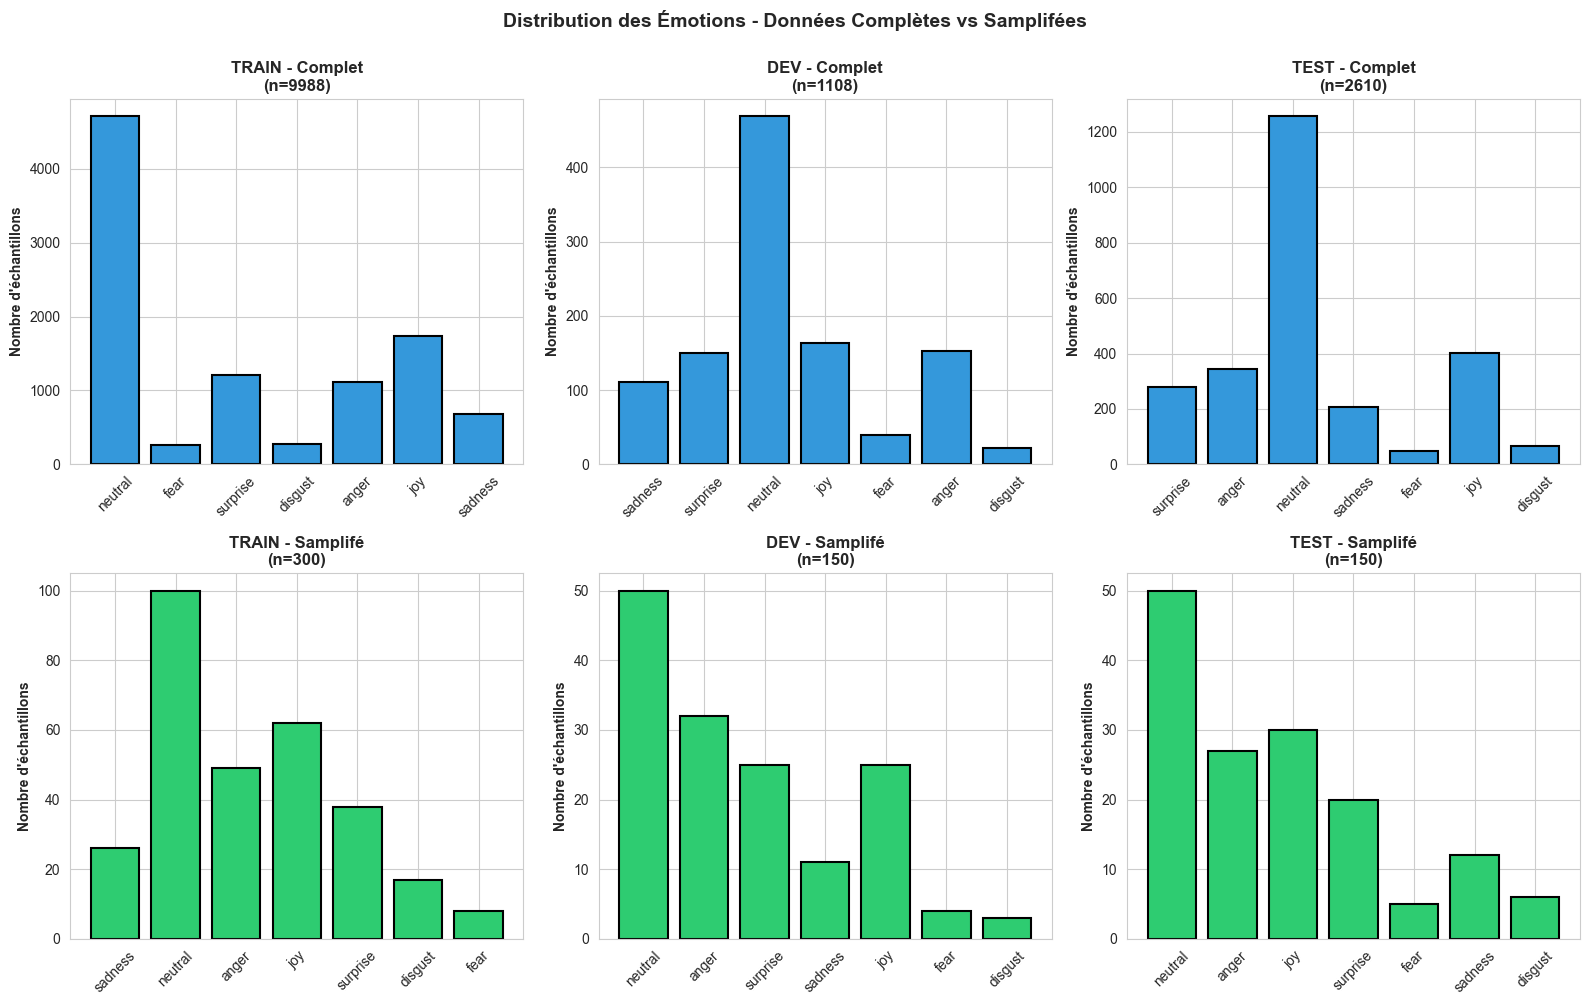

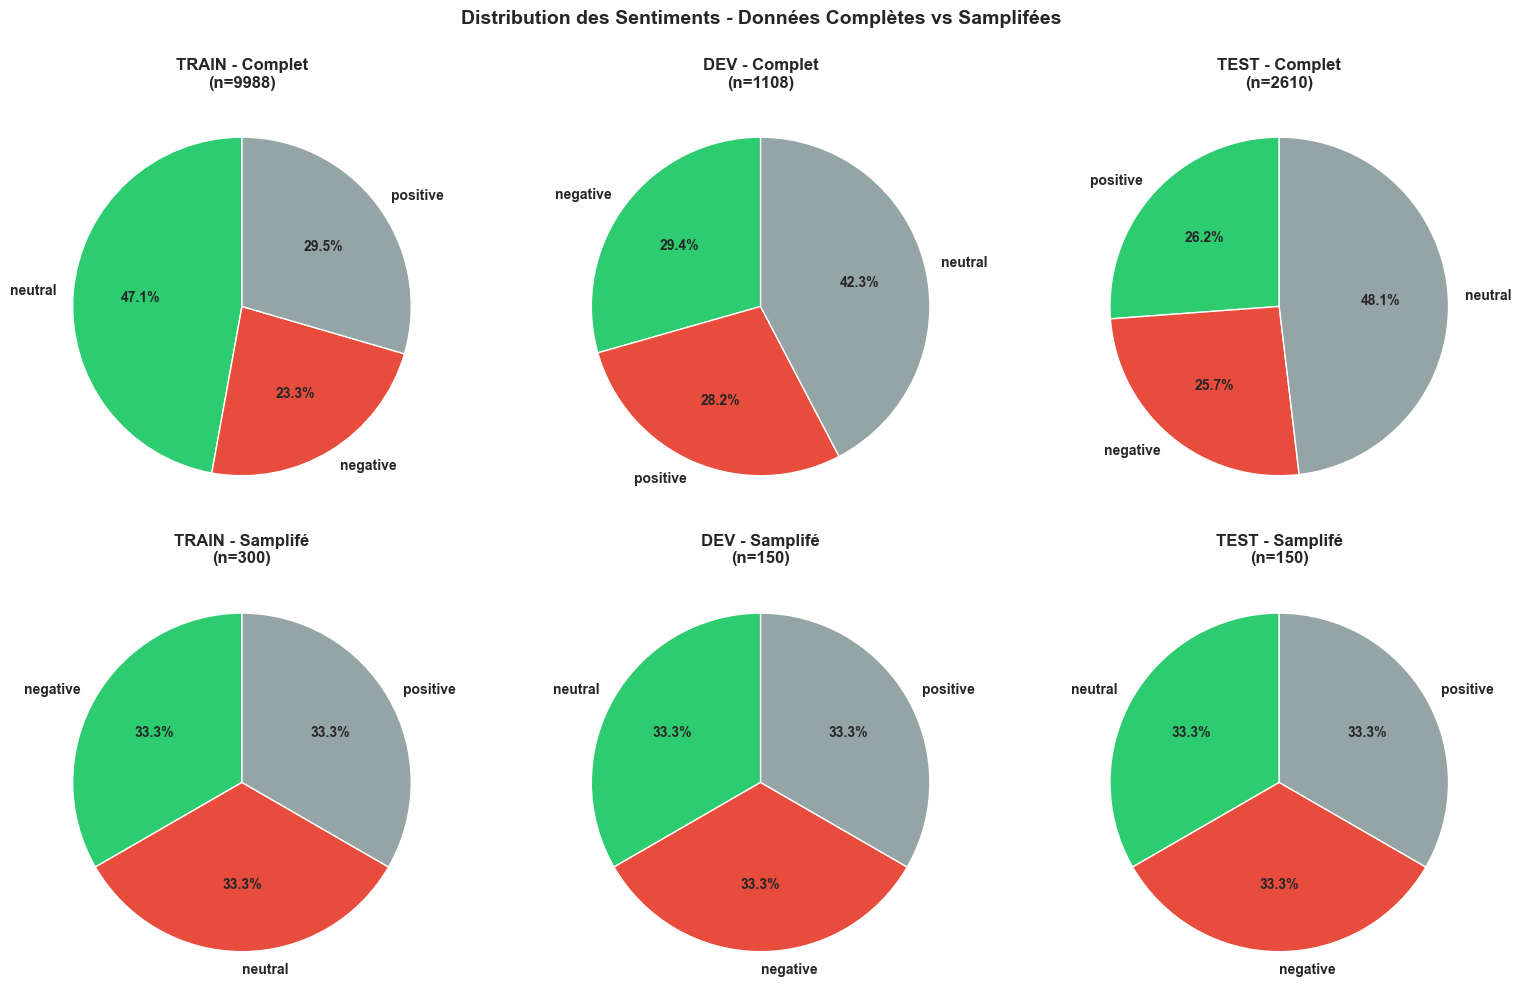

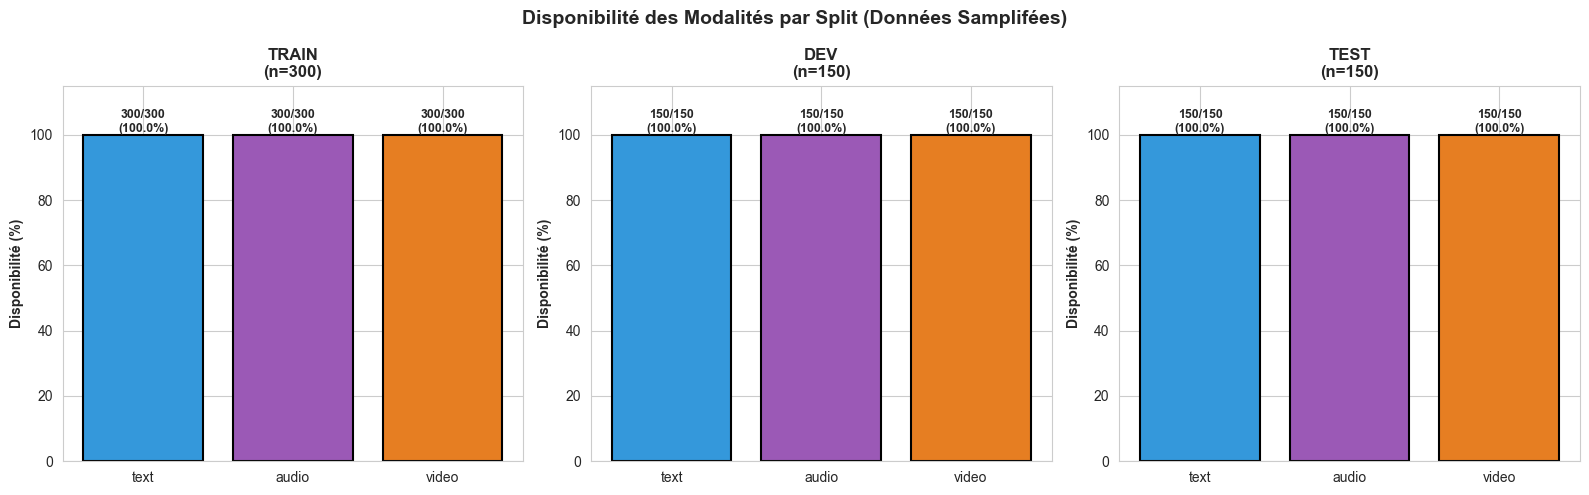

STATISTIQUES DÉTAILLÉES
TRAIN
Nombre d'échantillons:
  Complet:     9988
  Samplifé:     300
  Ratio:      3.0%

Distribution des sentiments (complet):
  negative  :  2331 ( 23.3%)
  neutral   :  4709 ( 47.1%)
  positive  :  2948 ( 29.5%)

Distribution des sentiments (samplifé):
  negative  :   100 ( 33.3%)
  neutral   :   100 ( 33.3%)
  positive  :   100 ( 33.3%)

Disponibilité des modalités (samplifé):
  Texte:    300/300 (100.0%)
  Audio:    300/300 (100.0%)
  Vidéo:    300/300 (100.0%)
DEV
Nombre d'échantillons:
  Complet:     1108
  Samplifé:     150
  Ratio:      13.5%

Distribution des sentiments (complet):
  negative  :   326 ( 29.4%)
  neutral   :   469 ( 42.3%)
  positive  :   313 ( 28.2%)

Distribution des sentiments (samplifé):
  negative  :    50 ( 33.3%)
  neutral   :    50 ( 33.3%)
  positive  :    50 ( 33.3%)

Disponibilité des modalités (samplifé):
  Texte:    150/150 (100.0%)
  Audio:    150/150 (100.0%)
  Vidéo:    150/150 (100.0%)
TEST
Nombre d'échantillons:
  Compl

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

#configuration matplotlib
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)
plt.rcParams['font.size'] = 10

print("ANALYSE COMPLÈTE DES DONNÉES MELD")

#DISTRIBUTION DES ÉMOTIONS PAR SPLIT
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Distribution des Émotions - Données Complètes vs Samplifées', 
             fontsize=14, fontweight='bold', y=1.00)

splits = ['train', 'dev', 'test']

#données complètes
for idx, split_name in enumerate(splits):
    ax = axes[0, idx]
    data = meld_data[split_name]
    
    #compter émotions
    emotion_counts = {}
    for sample in data:
        e = sample['emotion']
        emotion_counts[e] = emotion_counts.get(e, 0) + 1
    
    #bar chart
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())
    
    ax.bar(emotions, counts, color='#3498db', edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Nombre d\'échantillons', fontweight='bold')
    ax.set_title(f'{split_name.upper()} - Complet\n(n={len(data)})', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

#données samplifiées
for idx, split_name in enumerate(splits):
    ax = axes[1, idx]
    data = meld_data_sampled[split_name]
    
    #compter émotions
    emotion_counts = {}
    for sample in data:
        e = sample['emotion']
        emotion_counts[e] = emotion_counts.get(e, 0) + 1
    
    #bar chart
    emotions = list(emotion_counts.keys())
    counts = list(emotion_counts.values())
    
    ax.bar(emotions, counts, color='#2ecc71', edgecolor='black', linewidth=1.5)
    ax.set_ylabel('Nombre d\'échantillons', fontweight='bold')
    ax.set_title(f'{split_name.upper()} - Samplifé\n(n={len(data)})', fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#RÉPARTITION DES SENTIMENTS PAR SPLIT
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Distribution des Sentiments - Données Complètes vs Samplifées', 
             fontsize=14, fontweight='bold', y=1.00)

splits = ['train', 'dev', 'test']
colors = ['#2ecc71', '#e74c3c', '#95a5a6']  # Green, Red, Gray for pos/neg/neutral

#Données complètes
for idx, split_name in enumerate(splits):
    ax = axes[0, idx]
    data = meld_data[split_name]
    
    #compter sentiments
    sentiment_counts = {}
    for sample in data:
        s = sample['y']
        sentiment_counts[s] = sentiment_counts.get(s, 0) + 1
    
    #pie chart
    sentiments = list(sentiment_counts.keys())
    counts = list(sentiment_counts.values())
    
    ax.pie(counts, labels=sentiments, autopct='%1.1f%%', colors=colors, 
           startangle=90, textprops={'fontsize': 10, 'weight': 'bold'})
    ax.set_title(f'{split_name.upper()} - Complet\n(n={len(data)})', fontweight='bold')

#données samplifiées
for idx, split_name in enumerate(splits):
    ax = axes[1, idx]
    data = meld_data_sampled[split_name]
    
    #compter sentiments
    sentiment_counts = {}
    for sample in data:
        s = sample['y']
        sentiment_counts[s] = sentiment_counts.get(s, 0) + 1
    
    #pie chart
    sentiments = list(sentiment_counts.keys())
    counts = list(sentiment_counts.values())
    
    ax.pie(counts, labels=sentiments, autopct='%1.1f%%', colors=colors,
           startangle=90, textprops={'fontsize': 10, 'weight': 'bold'})
    ax.set_title(f'{split_name.upper()} - Samplifé\n(n={len(data)})', fontweight='bold')

plt.tight_layout()
plt.show()

#DISPONIBILITÉ DES MODALITÉS (TEXTE, AUDIO, VIDÉO)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Disponibilité des Modalités par Split (Données Samplifées)', 
             fontsize=14, fontweight='bold')

splits = ['train', 'dev', 'test']
modalities = ['text', 'audio', 'video']

for idx, split_name in enumerate(splits):
    ax = axes[idx]
    data = meld_data_sampled[split_name]
    
    #compter disponibilité
    modality_availability = {
        'text': 0,
        'audio': 0,
        'video': 0
    }
    
    for sample in data:
        #texte
        if sample.get('text') and len(str(sample['text']).strip()) > 0:
            modality_availability['text'] += 1
        
        #audio
        if sample.get('audio') is not None or sample.get('audio_mel') is not None:
            modality_availability['audio'] += 1
        
        #image
        if sample.get('face') is not None:
            modality_availability['video'] += 1
    
    #bar chart
    mods = list(modality_availability.keys())
    avail_counts = list(modality_availability.values())
    availability_pct = [count / len(data) * 100 for count in avail_counts]
    
    bars = ax.bar(mods, availability_pct, color=['#3498db', '#9b59b6', '#e67e22'],
                   edgecolor='black', linewidth=1.5)
    
    #ajouter pourcentages sur barres
    for bar, count, pct in zip(bars, avail_counts, availability_pct):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}/{len(data)}\n({pct:.1f}%)',
                ha='center', va='bottom', fontweight='bold', fontsize=9)
    
    ax.set_ylim(0, 110)
    ax.set_ylabel('Disponibilité (%)', fontweight='bold')
    ax.set_title(f'{split_name.upper()}\n(n={len(data)})', fontweight='bold')
    ax.set_ylim(0, 115)

plt.tight_layout()
plt.show()

#STATISTIQUES DÉTAILLÉES
print("STATISTIQUES DÉTAILLÉES")

for split_name in ['train', 'dev', 'test']:
    print(f"{split_name.upper()}")
    
    data_complete = meld_data[split_name]
    data_sample = meld_data_sampled[split_name]
    
    print(f"Nombre d'échantillons:")
    print(f"  Complet:    {len(data_complete):5d}")
    print(f"  Samplifé:   {len(data_sample):5d}")
    print(f"  Ratio:      {len(data_sample)/len(data_complete)*100:.1f}%")
    
    #sentiments complets
    sentiment_counts_full = {}
    for sample in data_complete:
        s = sample['y']
        sentiment_counts_full[s] = sentiment_counts_full.get(s, 0) + 1
    
    print(f"\nDistribution des sentiments (complet):")
    for sent in sorted(sentiment_counts_full.keys()):
        count = sentiment_counts_full[sent]
        pct = count / len(data_complete) * 100
        print(f"  {sent:10s}: {count:5d} ({pct:5.1f}%)")
    
    #sentiments samplifés
    sentiment_counts_samp = {}
    for sample in data_sample:
        s = sample['y']
        sentiment_counts_samp[s] = sentiment_counts_samp.get(s, 0) + 1
    
    print(f"\nDistribution des sentiments (samplifé):")
    for sent in sorted(sentiment_counts_samp.keys()):
        count = sentiment_counts_samp[sent]
        pct = count / len(data_sample) * 100
        print(f"  {sent:10s}: {count:5d} ({pct:5.1f}%)")
    
    #modalités
    text_count = sum(1 for s in data_sample if s.get('text') and len(str(s['text']).strip()) > 0)
    audio_count = sum(1 for s in data_sample if s.get('audio') is not None or s.get('audio_mel') is not None)
    video_count = sum(1 for s in data_sample if s.get('face') is not None)
    
    print(f"\nDisponibilité des modalités (samplifé):")
    print(f"  Texte:  {text_count:5d}/{len(data_sample)} ({text_count/len(data_sample)*100:5.1f}%)")
    print(f"  Audio:  {audio_count:5d}/{len(data_sample)} ({audio_count/len(data_sample)*100:5.1f}%)")
    print(f"  Vidéo:  {video_count:5d}/{len(data_sample)} ({video_count/len(data_sample)*100:5.1f}%)")


# 8. TextEncoder

Architecture avec token spécial learnable et Transformer.

In [8]:
class TextEncoder(nn.Module):
    #encodeur de texte
    def __init__(self, input_dim=768, seq_len=8, nhead=4, num_layers=2):
        super().__init__()
        
        #token spécial learnable Em
        self.Em = nn.Parameter(torch.randn(1, 1, input_dim))
        
        #transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=nhead,
            dim_feedforward=2048,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.seq_len = seq_len
        
    def forward(self, bert_output):
        #bert_output: (batch_size, seq_len, input_dim)
        batch_size = bert_output.size(0)
        
        #ajout embedding
        Em_expanded = self.Em.expand(batch_size, -1, -1)
        x = torch.cat([Em_expanded, bert_output], dim=1)
        
        #transformer
        x = self.transformer(x)
        
        #enlever token spécial
        return x[:, :self.seq_len, :]


#initialisation
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased").to(device)
text_encoder = TextEncoder().to(device)

print(f"TextEncoder: {sum(p.numel() for p in text_encoder.parameters()):,} params")

TextEncoder: 11,028,736 params


# 9.  Création encodeur audio et vidéo

Les features audio MELD sont des vecteurs pré-extraits (OpenSMILE, COVAREP, etc.).
Nous allons les "interpréter" pour générer des descriptions textuelles.

In [17]:
class AudioDescriptionGenerator(nn.Module):
    #genere encodages directement à partir de features audio
    def __init__(self, output_dim=768, seq_len=8):
        super().__init__()
        self.output_dim = output_dim
        self.seq_len = seq_len
        
        #projection et reduction dimension
        self.projection = nn.Linear(1, 1)
        self.adaptive_pool = nn.AdaptiveAvgPool1d(seq_len)
        
        #réseau d'encodage des coefficients projetés
        self.audio_encoder = nn.Sequential(
            nn.Linear(seq_len, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, output_dim)
        )
        
    def encode_features(self, audio_vector):
        #encode un vecteur audio en embedding (1, seq_len, output_dim)
        if audio_vector is None:
            return torch.zeros(1, self.seq_len, self.output_dim).to(device)
        
        try:
            #convertir en tensor
            if isinstance(audio_vector, np.ndarray):
                audio_tensor = torch.tensor(audio_vector, dtype=torch.float32).to(device)
            else:
                audio_tensor = audio_vector.to(device) if torch.is_tensor(audio_vector) else torch.tensor(audio_vector, dtype=torch.float32).to(device)
            
            # Flatten to 1D
            audio_tensor = audio_tensor.reshape(-1)
            
            if audio_tensor.numel() == 0:
                return torch.zeros(1, self.seq_len, self.output_dim).to(device)
            
            #normalisation (z-score)
            if len(audio_tensor) > 1:
                mean = audio_tensor.mean()
                std = audio_tensor.std()
                if std > 1e-6:
                    audio_tensor = (audio_tensor - mean) / (std + 1e-6)
            
            #reshape pour adaptive_avg_pool1d: (1, 1, N) - exactly 3D
            audio_reshaped = audio_tensor.view(1, 1, -1)  # (1, 1, N)
            
            #pooling adaptatif pour réduire à seq_len
            pooled = self.adaptive_pool(audio_reshaped)  # (1, 1, seq_len)
            pooled = pooled.view(1, -1)  # (1, seq_len)
            
            #encoder
            encoded = self.audio_encoder(pooled)  # (1, output_dim)
            
            #reshape en (1, seq_len, output_dim) en répétant
            result = encoded.view(1, 1, self.output_dim).repeat(1, self.seq_len, 1)  # (1, seq_len, output_dim)
            
            return result
        
        except Exception as e:
            print(f"Error encoding audio: {e}")
            return torch.zeros(1, self.seq_len, self.output_dim).to(device)


class VisionDescriptionGenerator(nn.Module):
    #genere encodages directement à partir de features visuelles
    def __init__(self, output_dim=768, seq_len=8):
        super().__init__()
        self.output_dim = output_dim
        self.seq_len = seq_len
        
        #embedding pour les émotions
        self.emotion_embedding = nn.Embedding(7, output_dim)
        
        #emotions: joy, sadness, anger, fear, surprise, disgust, neutral
        self.emotion_to_idx = {
            'joy': 0,
            'sadness': 1,
            'anger': 2,
            'fear': 3,
            'surprise': 4,
            'disgust': 5,
            'neutral': 6
        }
    
    def encode_emotion(self, emotion=None):
        #encode une émotion en embedding (1, seq_len, output_dim)
        if emotion is None:
            emotion = 'neutral'
        
        emotion = emotion.lower()
        emotion_idx = self.emotion_to_idx.get(emotion, 6)  #default to neutral
        
        #créer embedding
        emotion_tensor = torch.tensor([emotion_idx], dtype=torch.long).to(device)
        embedding = self.emotion_embedding(emotion_tensor)  # (1, output_dim)
        
        embedding = embedding.unsqueeze(0).repeat(1, self.seq_len, 1)
        
        return embedding


#initialisation
audio_desc_gen = AudioDescriptionGenerator().to(device)
vision_desc_gen = VisionDescriptionGenerator().to(device)

print(f"AudioDescriptionGenerator: {sum(p.numel() for p in audio_desc_gen.parameters()):,} params")
print(f"VisionDescriptionGenerator: {sum(p.numel() for p in vision_desc_gen.parameters()):,} params")

AudioDescriptionGenerator: 199,682 params
VisionDescriptionGenerator: 5,376 params


# 10. Fonction d'encodage textuel unifiée (encodage direct des modalités)

In [18]:
def encode_text_with_bert_and_transformer(text):
    #encode le texte avec BERT et TextEncoder
    if isinstance(text, str):
        text = [text]
    
    #tokenization
    tokens = tokenizer(text, return_tensors="pt", truncation=True, 
                      padding=True, max_length=128).to(device)
    
    #BERT
    with torch.no_grad():
        bert_output = bert(**tokens).last_hidden_state
    
    #TextEncoder
    encoded = text_encoder(bert_output)
    
    return encoded


def encode_audio_features(audio_vector):
    #encode directement les features audio
    if audio_vector is None:
        return torch.zeros(1, 8, 768).to(device)
    
    try:
        audio_np = np.array(audio_vector, dtype=np.float32)
        return audio_desc_gen.encode_features(audio_np)
    except:
        return torch.zeros(1, 8, 768).to(device)


def encode_vision_emotion(emotion):
    #encode directement l'émotion
    return vision_desc_gen.encode_emotion(emotion)


# 11. Attention (CrossModalAttention) et Fusion (MFU)

In [19]:
class CrossModalAttention(nn.Module):
    #attention multi-tête cross-modal
    def __init__(self, dim=768, nhead=4):
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=dim,
            num_heads=nhead,
            dropout=0.1,
            batch_first=True
        )
    
    def forward(self, query, key_value):
        attn_output, _ = self.multihead_attn(
            query=query,
            key=key_value,
            value=key_value
        )
        return attn_output


class MFU(nn.Module):
    #module de Fusion Multimodale
    def __init__(self, dim=768):
        super().__init__()
        
        self.proj_audio = nn.Linear(dim, dim)
        self.proj_vision = nn.Linear(dim, dim)
        
        self.cross_attn_audio = CrossModalAttention(dim)
        self.cross_attn_vision = CrossModalAttention(dim)
        
        #poids apprenables (CRITIQUE)
        self.alpha = nn.Parameter(torch.tensor(1.0))
        self.beta = nn.Parameter(torch.tensor(1.0))
        
        self.layer_norm = nn.LayerNorm(dim)
    
    def forward(self, X_text, X_audio, X_vision, prev_fusion=None):
        #projections
        X_audio_proj = self.proj_audio(X_audio)
        X_vision_proj = self.proj_vision(X_vision)
        
        #attentions croisées
        attn_audio = self.cross_attn_audio(X_text, X_audio_proj)
        attn_vision = self.cross_attn_vision(X_text, X_vision_proj)
        
        #MFU: Fusion pondérée
        if prev_fusion is None:
            prev_fusion = X_text
        
        fusion = prev_fusion + self.alpha * attn_audio + self.beta * attn_vision
        fusion = self.layer_norm(fusion)
        
        return fusion

# 12. DEVANet et Métriques

In [20]:
class DEVANet(nn.Module):
    #réseau DEVANet pour la fusion multimodale
    def __init__(self, hidden_dim=768, output_dim=1):
        super().__init__()
        
        self.mfu = MFU(dim=hidden_dim)
        
        self.predictor = nn.Sequential(
            nn.Linear(hidden_dim * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, output_dim)
        )
    
    def forward(self, X_text, X_audio_desc, X_vision_desc):
        #fusion MFU
        fused = self.mfu(X_text, X_audio_desc, X_vision_desc)
        
        #aplatir et prédire
        batch_size = fused.size(0)
        fused_flat = fused.reshape(batch_size, -1)
        output = self.predictor(fused_flat)
        
        return output.squeeze(-1)


def evaluate_metrics(labels, predictions):
    #calcule les métriques académiques
    if torch.is_tensor(labels):
        labels = labels.cpu().numpy()
    if torch.is_tensor(predictions):
        predictions = predictions.cpu().detach().numpy()
    
    #Acc-2: Classification binaire (positive vs negative)
    labels_binary = (labels > 0).astype(int)
    preds_binary = (predictions > 0).astype(int)
    acc2 = accuracy_score(labels_binary, preds_binary)
    
    #Acc-5: Classification 5-classes (basée sur quantiles)
    labels_5class = pd.qcut(labels, q=5, labels=False, duplicates='drop')
    preds_5class = pd.qcut(predictions, q=5, labels=False, duplicates='drop')
    acc5 = accuracy_score(labels_5class, preds_5class)
    
    #Acc-7: Classification 7-classes (basée sur quantiles)
    labels_7class = pd.qcut(labels, q=7, labels=False, duplicates='drop')
    preds_7class = pd.qcut(predictions, q=7, labels=False, duplicates='drop')
    acc7 = accuracy_score(labels_7class, preds_7class)
    
    #F1-Score
    f1 = f1_score(labels_binary, preds_binary, average='weighted', zero_division=0)
    
    #MAE
    mae = mean_absolute_error(labels, predictions)
    
    #pearson
    if len(labels) > 1:
        pearson, _ = pearsonr(labels, predictions)
    else:
        pearson = 0.0
    
    return {
        'acc2': acc2,
        'acc5': acc5,
        'acc7': acc7,
        'f1': f1,
        'mae': mae,
        'pearson': pearson
    }

#affichage et métriques
def print_metrics(metrics, prefix=""):
    print(f"\n{prefix}Metrics:")
    print(f"  Acc-2: {metrics['acc2']:.4f}")
    print(f"  Acc-5: {metrics['acc5']:.4f}")
    print(f"  Acc-7: {metrics['acc7']:.4f}")
    print(f"  F1:    {metrics['f1']:.4f}")
    print(f"  MAE:   {metrics['mae']:.4f}")
    print(f"  Pear:  {metrics['pearson']:.4f}")


#initialisation
deva_model = DEVANet().to(device)
optimizer = torch.optim.AdamW(deva_model.parameters(), lr=5e-5, weight_decay=0.01)
loss_fn = nn.MSELoss()

print(f"DEVANet: {sum(p.numel() for p in deva_model.parameters()):,} params")

DEVANet: 7,497,091 params


# 13. Dataset PyTorch pour MELD

In [21]:
class MELDDataset(Dataset):
    #Dataset personnalisé pour MELD
    def __init__(self, data_list):
        self.data = data_list
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = self.data[idx]
        
        return {
            'text': sample['text'],
            'sentiment': convert_sentiment_to_score(sample['y']),
            'emotion': sample.get('emotion', 'neutral'),
            'audio': sample.get('audio'),
            'audio_mel': sample.get('audio_mel'),
            'face': sample.get('face'),
        }


def collate_fn_meld(batch):
    #fonction de collate personnalisée pour MELD
    texts = [item['text'] for item in batch]
    sentiments = torch.tensor([item['sentiment'] for item in batch], dtype=torch.float32)
    emotions = [item['emotion'] for item in batch]
    
    #garder audio/audio_mel/face comme listes (pas de stack)
    audios = [item['audio'] for item in batch]
    audio_mels = [item['audio_mel'] for item in batch]
    faces = [item['face'] for item in batch]
    
    return {
        'text': texts,
        'sentiment': sentiments,
        'emotion': emotions,
        'audio': audios,
        'audio_mel': audio_mels,
        'face': faces
    }

#créer datasets à partir des données samplifées
train_dataset = MELDDataset(meld_data_sampled['train'])
dev_dataset = MELDDataset(meld_data_sampled['dev'])
test_dataset = MELDDataset(meld_data_sampled['test'])

#dataloaders avec batch_size adapté à la mémoire et collate_fn personnalisé
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn_meld)
dev_loader = DataLoader(dev_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_meld)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn_meld)

print(f"\nDatasets created from sampled data:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Dev batches: {len(dev_loader)}")
print(f"  Test batches: {len(test_loader)}")


Datasets created from sampled data:
  Train batches: 19
  Dev batches: 10
  Test batches: 10


# 14. Boucle d'Entraînement (avec données MELD)

In [22]:
def train_epoch(model, dataloader, optimizer, loss_fn):
    #entraîne le modèle pour une époque
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in tqdm(dataloader, desc="Training"):
        #extraction données
        texts = batch['text']
        labels = batch['sentiment'].to(device)
        emotions = batch['emotion']
        audios = batch['audio']
        
        #encoder le texte principal
        X_text = encode_text_with_bert_and_transformer(texts)
        
        #encoder les features audio
        X_audio_list = [encode_audio_features(audio) for audio in audios]
        X_audio_desc = torch.cat(X_audio_list, dim=0)  # concatener le batch
        
        #encoder les émotions (vision)
        X_vision_list = [encode_vision_emotion(emotion) for emotion in emotions]
        X_vision_desc = torch.cat(X_vision_list, dim=0)  # concatener le batch
        
        #prédiction
        preds = model(X_text, X_audio_desc, X_vision_desc)
        
        #loss et backprop
        loss = loss_fn(preds, labels)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    metrics = evaluate_metrics(np.array(all_labels), np.array(all_preds))
    
    return avg_loss, metrics


def evaluate(model, dataloader, loss_fn):
    #évaluation du modèle
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            texts = batch['text']
            labels = batch['sentiment'].to(device)
            emotions = batch['emotion']
            audios = batch['audio']
            
            #encoder le texte
            X_text = encode_text_with_bert_and_transformer(texts)
            
            #encoder les features audio
            X_audio_list = [encode_audio_features(audio) for audio in audios]
            X_audio_desc = torch.cat(X_audio_list, dim=0)
            
            #encoder les émotions (vision)
            X_vision_list = [encode_vision_emotion(emotion) for emotion in emotions]
            X_vision_desc = torch.cat(X_vision_list, dim=0)
            
            preds = model(X_text, X_audio_desc, X_vision_desc)
            loss = loss_fn(preds, labels)
            
            total_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    metrics = evaluate_metrics(np.array(all_labels), np.array(all_preds))
    
    return avg_loss, metrics


# 15. Entraînement principal

In [23]:
print("ENTRAÎNEMENT SUR DONNÉES MELD")

num_epochs = 10
best_dev_loss = float('inf')

for epoch in range(num_epochs):
    print(f"\n{'='*70}")
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{'='*70}")
    
    #entraînement
    train_loss, train_metrics = train_epoch(deva_model, train_loader, optimizer, loss_fn)
    print(f"\nTrain Loss: {train_loss:.4f}")
    print_metrics(train_metrics, prefix="Train ")
    
    #validation
    dev_loss, dev_metrics = evaluate(deva_model, dev_loader, loss_fn)
    print(f"\nDev Loss: {dev_loss:.4f}")
    print_metrics(dev_metrics, prefix="Dev ")
    
    #sauvegarde du meilleur modèle
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': deva_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'dev_loss': dev_loss,
            'dev_metrics': dev_metrics,
            'alpha': deva_model.mfu.alpha.item(),
            'beta': deva_model.mfu.beta.item()
        }, 'best_deva_meld.pt')
        print(f"\nMeilleur modele sauvegardé (Dev loss: {dev_loss:.4f})")

print("ENTRAÎNEMENT TERMINÉ")

ENTRAÎNEMENT SUR DONNÉES MELD

Epoch 1/10


Training: 100%|██████████| 19/19 [00:15<00:00,  1.19it/s]




Train Loss: 0.3349

Train Metrics:
  Acc-2: 0.7200
  Acc-5: 0.2333
  Acc-7: 0.1600
  F1:    0.7278
  MAE:   0.4650
  Pear:  0.7114


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]




Dev Loss: 0.0724

Dev Metrics:
  Acc-2: 0.7933
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    0.7988
  MAE:   0.2089
  Pear:  0.9863

Meilleur modele sauvegardé (Dev loss: 0.0724)

Epoch 2/10


Training: 100%|██████████| 19/19 [00:16<00:00,  1.17it/s]



Train Loss: 0.0577

Train Metrics:
  Acc-2: 0.8167
  Acc-5: 0.2000
  Acc-7: 0.1433
  F1:    0.8218
  MAE:   0.1851
  Pear:  0.9596


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]




Dev Loss: 0.0072

Dev Metrics:
  Acc-2: 0.9533
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    0.9540
  MAE:   0.0668
  Pear:  0.9956

Meilleur modele sauvegardé (Dev loss: 0.0072)

Epoch 3/10


Training: 100%|██████████| 19/19 [00:16<00:00,  1.12it/s]



Train Loss: 0.0389

Train Metrics:
  Acc-2: 0.8400
  Acc-5: 0.2000
  Acc-7: 0.1433
  F1:    0.8446
  MAE:   0.1497
  Pear:  0.9714


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]



Dev Loss: 0.0083

Dev Metrics:
  Acc-2: 0.9400
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    0.9411
  MAE:   0.0685
  Pear:  0.9944

Epoch 4/10


Training: 100%|██████████| 19/19 [00:17<00:00,  1.08it/s]



Train Loss: 0.0331

Train Metrics:
  Acc-2: 0.8067
  Acc-5: 0.2000
  Acc-7: 0.1433
  F1:    0.8120
  MAE:   0.1360
  Pear:  0.9752


Evaluating: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]




Dev Loss: 0.0077

Dev Metrics:
  Acc-2: 1.0000
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    1.0000
  MAE:   0.0713
  Pear:  0.9970

Epoch 5/10


Training: 100%|██████████| 19/19 [00:18<00:00,  1.04it/s]



Train Loss: 0.0272

Train Metrics:
  Acc-2: 0.8567
  Acc-5: 0.2000
  Acc-7: 0.1433
  F1:    0.8607
  MAE:   0.1257
  Pear:  0.9795


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.43it/s]




Dev Loss: 0.0074

Dev Metrics:
  Acc-2: 0.9800
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    0.9801
  MAE:   0.0716
  Pear:  0.9975

Epoch 6/10


Training: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]



Train Loss: 0.0296

Train Metrics:
  Acc-2: 0.8167
  Acc-5: 0.2000
  Acc-7: 0.1433
  F1:    0.8218
  MAE:   0.1285
  Pear:  0.9785


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]




Dev Loss: 0.0076

Dev Metrics:
  Acc-2: 0.9933
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    0.9933
  MAE:   0.0705
  Pear:  0.9951

Epoch 7/10


Training: 100%|██████████| 19/19 [00:17<00:00,  1.07it/s]



Train Loss: 0.0334

Train Metrics:
  Acc-2: 0.8467
  Acc-5: 0.2000
  Acc-7: 0.1433
  F1:    0.8510
  MAE:   0.1379
  Pear:  0.9755


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]



Dev Loss: 0.0093

Dev Metrics:
  Acc-2: 1.0000
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    1.0000
  MAE:   0.0818
  Pear:  0.9977

Epoch 8/10


Training: 100%|██████████| 19/19 [00:17<00:00,  1.10it/s]




Train Loss: 0.0266

Train Metrics:
  Acc-2: 0.8633
  Acc-5: 0.2000
  Acc-7: 0.1433
  F1:    0.8672
  MAE:   0.1244
  Pear:  0.9799


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]




Dev Loss: 0.0093

Dev Metrics:
  Acc-2: 0.9867
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    0.9867
  MAE:   0.0686
  Pear:  0.9959

Epoch 9/10


Training: 100%|██████████| 19/19 [00:16<00:00,  1.13it/s]



Train Loss: 0.0274

Train Metrics:
  Acc-2: 0.8567
  Acc-5: 0.2000
  Acc-7: 0.1433
  F1:    0.8607
  MAE:   0.1203
  Pear:  0.9795


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.54it/s]




Dev Loss: 0.0053

Dev Metrics:
  Acc-2: 0.9200
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    0.9217
  MAE:   0.0511
  Pear:  0.9978

Meilleur modele sauvegardé (Dev loss: 0.0053)

Epoch 10/10


Training: 100%|██████████| 19/19 [00:18<00:00,  1.03it/s]



Train Loss: 0.0270

Train Metrics:
  Acc-2: 0.8467
  Acc-5: 0.2000
  Acc-7: 0.1433
  F1:    0.8510
  MAE:   0.1199
  Pear:  0.9797


Evaluating: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Dev Loss: 0.0059

Dev Metrics:
  Acc-2: 0.8467
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    0.8510
  MAE:   0.0594
  Pear:  0.9988
ENTRAÎNEMENT TERMINÉ


# 16. Évaluation Finale sur Test Set

ÉVALUATION FINALE SUR TEST SET


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]




Test Loss: 0.0054

Test Metrics:
  Acc-2: 0.8733
  Acc-5: 0.2000
  Acc-7: 0.1467
  F1:    0.8768
  MAE:   0.0518
  Pear:  0.9975
ANALYSE DES POIDS APPRIS (MFU)

Poids bruts:
  Alpha (Audio weight):  0.9973
  Beta (Vision weight):  1.0011

Contribution RELATIVE (normalisée):
  Audio (Alpha):  49.9%
  Vision (Beta):  50.1%

✓ Le modèle PRIVILÉGIE LA VISION (+0.2%)


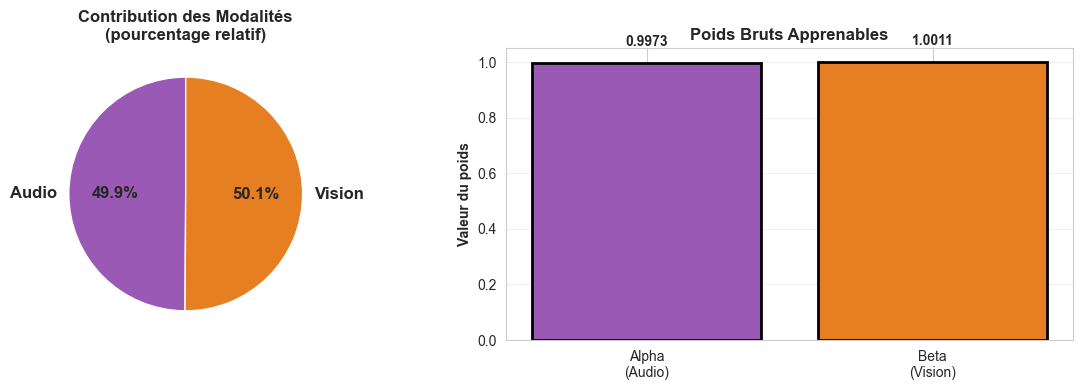

In [24]:
#charger meilleur modèle
checkpoint = torch.load('best_deva_meld.pt', weights_only=False)
deva_model.load_state_dict(checkpoint['model_state_dict'])

print("ÉVALUATION FINALE SUR TEST SET")

test_loss, test_metrics = evaluate(deva_model, test_loader, loss_fn)

print(f"\nTest Loss: {test_loss:.4f}")
print_metrics(test_metrics, prefix="Test ")

print("ANALYSE DES POIDS APPRIS (MFU)")

alpha = checkpoint['alpha']
beta = checkpoint['beta']

print(f"\n{'='*50}")
print(f"Poids bruts:")
print(f"  Alpha (Audio weight):  {alpha:.4f}")
print(f"  Beta (Vision weight):  {beta:.4f}")
print(f"{'='*50}")

total = abs(alpha) + abs(beta)
if total > 0:
    audio_contrib = abs(alpha) / total * 100
    vision_contrib = abs(beta) / total * 100
    
    print(f"\nContribution RELATIVE (normalisée):")
    print(f"  Audio (Alpha):  {audio_contrib:.1f}%")
    print(f"  Vision (Beta):  {vision_contrib:.1f}%")
    print(f"  {'='*50}")
    
    if audio_contrib > vision_contrib:
        diff = audio_contrib - vision_contrib
        print(f"\n✓ Le modèle PRIVILÉGIE L'AUDIO (+{diff:.1f}%)")
    elif vision_contrib > audio_contrib:
        diff = vision_contrib - audio_contrib
        print(f"\n✓ Le modèle PRIVILÉGIE LA VISION (+{diff:.1f}%)")
    else:
        print(f"\n✓ Le modèle ÉQUILIBRE AUDIO et VISION")
    
    # Visualisation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Pie chart
    colors = ['#9b59b6', '#e67e22']
    ax1.pie([audio_contrib, vision_contrib], 
            labels=['Audio', 'Vision'], 
            autopct='%1.1f%%',
            colors=colors,
            startangle=90,
            textprops={'fontsize': 12, 'weight': 'bold'})
    ax1.set_title('Contribution des Modalités\n(pourcentage relatif)', fontweight='bold', fontsize=12)
    
    # Bar chart avec valeurs brutes
    ax2.bar(['Alpha\n(Audio)', 'Beta\n(Vision)'], [alpha, beta], color=colors, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Valeur du poids', fontweight='bold')
    ax2.set_title('Poids Bruts Apprenables', fontweight='bold', fontsize=12)
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs sur les barres
    for i, (label, val) in enumerate(zip(['Alpha', 'Beta'], [alpha, beta])):
        ax2.text(i, val + 0.05, f'{val:.4f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# 17. Test sur exemples spécifiques

In [25]:
#tester sur quelques exemples du test set
deva_model.eval()

print("EXEMPLES DE PRÉDICTIONS")

test_samples = meld_data['test'][:5]

with torch.no_grad():
    for i, sample in enumerate(test_samples):
        text = sample['text']
        true_sentiment = sample['y']
        emotion = sample.get('emotion', 'neutral')
        audio = sample.get('audio')
        
        #pipeline
        X_text = encode_text_with_bert_and_transformer([text])
        X_audio_desc = encode_audio_features(audio)
        X_vision_desc = encode_vision_emotion(emotion)
        
        pred_score = deva_model(X_text, X_audio_desc, X_vision_desc).item()
        
        #déterminer sentiment prédit
        if pred_score > 0.3:
            pred_sentiment = "positive"
        elif pred_score < -0.3:
            pred_sentiment = "negative"
        else:
            pred_sentiment = "neutral"
        
        print(f"\nExample {i+1}:")
        print(f"  Text: '{text}'")
        print(f"  True: {true_sentiment} | Predicted: {pred_sentiment} (score: {pred_score:.3f})")
        print(f"  Emotion: {emotion}")
        print(f"  {'✓ Prédiction OK' if true_sentiment == pred_sentiment else '✗ Prédiction KO'}")


EXEMPLES DE PRÉDICTIONS

Example 1:
  Text: 'Why do all you’re coffee mugs have numbers on the bottom?'
  True: positive | Predicted: positive (score: 1.015)
  Emotion: surprise
  ✓ Prédiction OK

Example 2:
  Text: 'Oh. That’s so Monica can keep track. That way if one on them is missing, she can be like, Where’s number 27?!’'
  True: negative | Predicted: negative (score: -0.842)
  Emotion: anger
  ✓ Prédiction OK

Example 3:
  Text: 'Y'know what?'
  True: neutral | Predicted: neutral (score: -0.015)
  Emotion: neutral
  ✓ Prédiction OK

Example 4:
  Text: 'Me taking care of you is no problem, huh?'
  True: neutral | Predicted: neutral (score: -0.013)
  Emotion: neutral
  ✓ Prédiction OK

Example 5:
  Text: 'You guys feel safe.'
  True: neutral | Predicted: neutral (score: -0.080)
  Emotion: neutral
  ✓ Prédiction OK

Example 4:
  Text: 'Me taking care of you is no problem, huh?'
  True: neutral | Predicted: neutral (score: -0.013)
  Emotion: neutral
  ✓ Prédiction OK

Example 5:
  T